In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/dustywhite7/Econ8310/master/AssignmentData/cookie_cats.csv')

In [3]:
# Prepare data for analysis
gate_30_data = data[data['version'] == 'gate_30']
gate_40_data = data[data['version'] == 'gate_40']

# Extract 1-day and 7-day retention data
retention_1_gate_30 = gate_30_data['retention_1'].astype(int).values
retention_1_gate_40 = gate_40_data['retention_1'].astype(int).values
retention_7_gate_30 = gate_30_data['retention_7'].astype(int).values
retention_7_gate_40 = gate_40_data['retention_7'].astype(int).values

In [4]:
# Bayesian model for 1-day retention
with pm.Model() as model_1_day:
    # Define priors for 1-day retention model
    p_gate_30 = pm.Beta('p_gate_30', alpha=1, beta=1)
    p_gate_40 = pm.Beta('p_gate_40', alpha=1, beta=1)

    obs_gate_30 = pm.Binomial('obs_gate_30', n=len(retention_1_gate_30), p=p_gate_30, observed=sum(retention_1_gate_30))
    obs_gate_40 = pm.Binomial('obs_gate_40', n=len(retention_1_gate_40), p=p_gate_40, observed=sum(retention_1_gate_40))

    # Calculate difference in retention rates for 1-day retention
    diff_1_day = pm.Deterministic('diff_1_day', p_gate_40 - p_gate_30)

    # Sample from the posterior for 1-day retention
    trace_1_day = pm.sample(2000, return_inferencedata=True)

Output()

Output()

In [5]:
# Bayesian model for 7-day retention
with pm.Model() as model_7_day:
    # Define priors for 7-day retention model
    p_gate_30 = pm.Beta('p_gate_30', alpha=1, beta=1)
    p_gate_40 = pm.Beta('p_gate_40', alpha=1, beta=1)

    obs_gate_30 = pm.Binomial('obs_gate_30', n=len(retention_7_gate_30), p=p_gate_30, observed=sum(retention_7_gate_30))
    obs_gate_40 = pm.Binomial('obs_gate_40', n=len(retention_7_gate_40), p=p_gate_40, observed=sum(retention_7_gate_40))

    # Calculate difference in retention rates for 7-day retention
    diff_7_day = pm.Deterministic('diff_7_day', p_gate_40 - p_gate_30)

    # Sample from the posterior for 7-day retention
    trace_7_day = pm.sample(2000, return_inferencedata=True)

Output()

Output()

array([[<Axes: title={'center': 'diff_7_day'}>,
        <Axes: title={'center': 'diff_7_day'}>]], dtype=object)

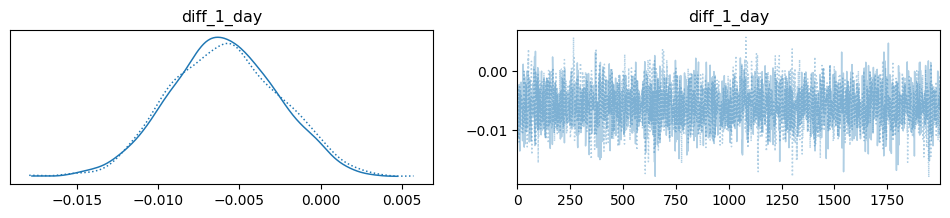

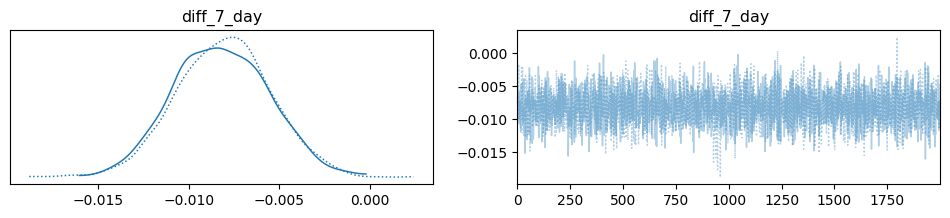

In [6]:
# Visualize posterior distributions
az.plot_trace(trace_1_day, var_names=['diff_1_day'])
az.plot_trace(trace_7_day, var_names=['diff_7_day'])

In [7]:
# Analyze posterior distributions for 1-day and 7-day
diff_1_day_samples = trace_1_day.posterior['diff_1_day'].values.flatten()
diff_1_day_mean = np.mean(diff_1_day_samples)
diff_1_day_ci = np.percentile(diff_1_day_samples, [2.5, 97.5])

diff_7_day_samples = trace_7_day.posterior['diff_7_day'].values.flatten()
diff_7_day_mean = np.mean(diff_7_day_samples)
diff_7_day_ci = np.percentile(diff_7_day_samples, [2.5, 97.5])

print(f"1-day retention difference mean: {diff_1_day_mean}")
print(f"1-day retention 95% credible interval: {diff_1_day_ci}")
print(f"7-day retention difference mean: {diff_7_day_mean}")
print(f"7-day retention 95% credible interval: {diff_7_day_ci}")

1-day retention difference mean: -0.005932945161154461
1-day retention 95% credible interval: [-0.01233071  0.00051987]
7-day retention difference mean: -0.008145771320199561
7-day retention 95% credible interval: [-0.01320801 -0.0030204 ]


(0.43, 0.46)

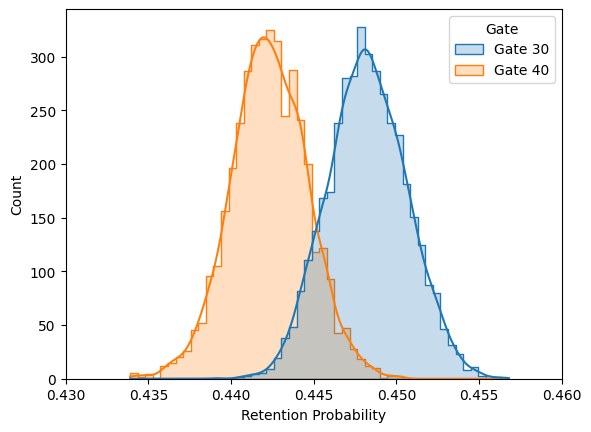

In [8]:
# Create stacked visualization for 1-day retention
p_gate_30_samples_1d = trace_1_day.posterior['p_gate_30'].values.flatten()
p_gate_40_samples_1d = trace_1_day.posterior['p_gate_40'].values.flatten()

p_gate_30_df_1d = pd.DataFrame(p_gate_30_samples_1d, columns=['Retention Probability'])
p_gate_30_df_1d['Gate'] = 'Gate 30'

p_gate_40_df_1d = pd.DataFrame(p_gate_40_samples_1d, columns=['Retention Probability'])
p_gate_40_df_1d['Gate'] = 'Gate 40'

# Concatenate dataframes and plot distributions for 1-day retention
retention_prob_data_1d = pd.concat([p_gate_30_df_1d, p_gate_40_df_1d], axis=0).reset_index(drop=True)
plot_1d = sns.histplot(data=retention_prob_data_1d, x='Retention Probability', hue='Gate', kde=True, bins=50, element='step')
plot_1d.set_xlim(0.43, 0.46)

(0.17, 0.2)

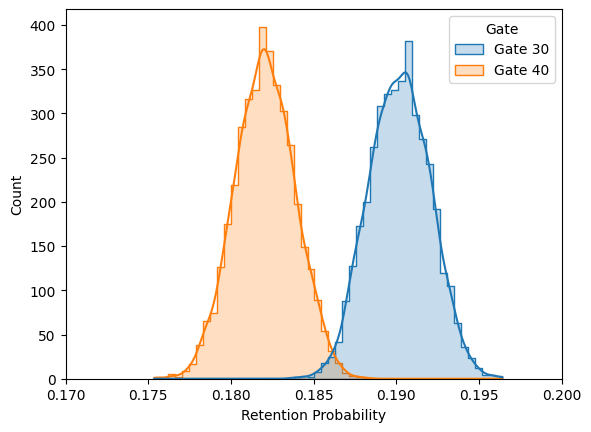

In [9]:
# Create stacked visualization for 7-day retention
p_gate_30_samples_7d = trace_7_day.posterior['p_gate_30'].values.flatten()
p_gate_40_samples_7d = trace_7_day.posterior['p_gate_40'].values.flatten()

p_gate_30_df_7d = pd.DataFrame(p_gate_30_samples_7d, columns=['Retention Probability'])
p_gate_30_df_7d['Gate'] = 'Gate 30'

p_gate_40_df_7d = pd.DataFrame(p_gate_40_samples_7d, columns=['Retention Probability'])
p_gate_40_df_7d['Gate'] = 'Gate 40'

# Concatenate dataframes and plot distributions for 7-day retention
retention_prob_data_7d = pd.concat([p_gate_30_df_7d, p_gate_40_df_7d], axis=0).reset_index(drop=True)
plot_7d = sns.histplot(data=retention_prob_data_7d, x='Retention Probability', hue='Gate', kde=True, bins=50, element='step')
plot_7d.set_xlim(0.17, 0.2)

In [10]:
# Bayesian Bernoulli model for 1-day retention
with pm.Model() as bernoulli_ab_test_model:
    # Define priors for 1-day retention model (Bernoulli A/B test)
    p_gate_30 = pm.Beta('p_gate_30', alpha=2, beta=5)
    p_gate_40 = pm.Beta('p_gate_40', alpha=2, beta=5)

    obs_gate_30 = pm.Bernoulli('obs_gate_30', p=p_gate_30, observed=retention_1_gate_30)
    obs_gate_40 = pm.Bernoulli('obs_gate_40', p=p_gate_40, observed=retention_1_gate_40)

    # Calculate difference in retention rates for 1-day retention
    diff_1_day = pm.Deterministic('diff_1_day', p_gate_40 - p_gate_30)

    bernoulli_trace_1d = pm.sample(2000, return_inferencedata=True)


Output()

Output()

1-day retention difference mean (bernoulli a/b test): -0.005921568147669806
1-day retention 95% credible interval (bernoulli a/b test): [-0.01248892  0.00049275]


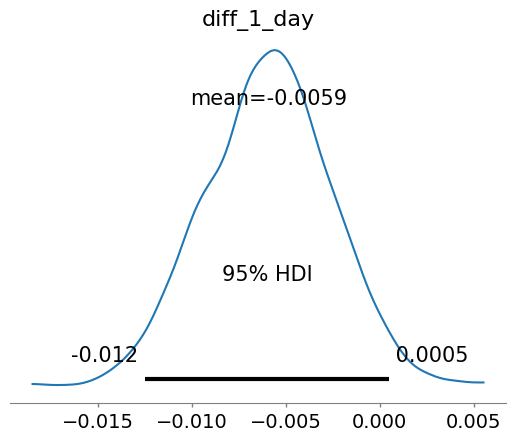

In [11]:
# Visualize posterior distributions for 1-day retention (Bernoulli A/B test)
az.plot_posterior(bernoulli_trace_1d, var_names=['diff_1_day'], hdi_prob=0.95)

# Analyze posterior distributions for 1-day retention (Bernoulli A/B test)
diff_1_day_samples = bernoulli_trace_1d.posterior['diff_1_day'].values.flatten()
diff_1_day_mean = np.mean(diff_1_day_samples)
diff_1_day_ci = np.percentile(diff_1_day_samples, [2.5, 97.5])

print(f"1-day retention difference mean (bernoulli a/b test): {diff_1_day_mean}")
print(f"1-day retention 95% credible interval (bernoulli a/b test): {diff_1_day_ci}")

(0.43, 0.46)

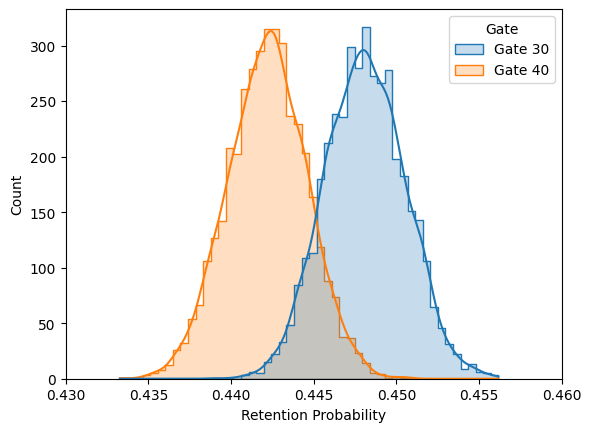

In [12]:
# Create stacked visualization for 1-day retention
p_gate_30_samples_1d = bernoulli_trace_1d.posterior['p_gate_30'].values.flatten()
p_gate_40_samples_1d = bernoulli_trace_1d.posterior['p_gate_40'].values.flatten()

p_gate_30_df_1d = pd.DataFrame(p_gate_30_samples_1d, columns=['Retention Probability'])
p_gate_30_df_1d['Gate'] = 'Gate 30'

p_gate_40_df_1d = pd.DataFrame(p_gate_40_samples_1d, columns=['Retention Probability'])
p_gate_40_df_1d['Gate'] = 'Gate 40'

# Concatenate dataframes and plot distributions for 1-day retention (Bernoulli A/B test)
retention_prob_data_1d = pd.concat([p_gate_30_df_1d, p_gate_40_df_1d], axis=0).reset_index(drop=True)
plot_1d = sns.histplot(data=retention_prob_data_1d, x='Retention Probability', hue='Gate', kde=True, bins=50, element='step')
plot_1d.set_xlim(0.43, 0.46)

In [13]:
# Bayesian Bernoulli model for 7-day retention
with pm.Model() as bernoulli_ab_test_model_7d:
    # priors
    p_gate_30_7d = pm.Beta('p_gate_30_7d', alpha=2, beta=5)
    p_gate_40_7d = pm.Beta('p_gate_40_7d', alpha=2, beta=5)

    obs_gate_30_7d = pm.Bernoulli('obs_gate_30_7d', p=p_gate_30_7d, observed=retention_7_gate_30)
    obs_gate_40_7d = pm.Bernoulli('obs_gate_40_7d', p=p_gate_40_7d, observed=retention_7_gate_40)

    # Calculate difference in retention rates for 7-day retention
    diff_7_day = pm.Deterministic('diff_7_day', p_gate_40_7d - p_gate_30_7d)

    bernoulli_trace_7d = pm.sample(2000, return_inferencedata=True)

Output()

Output()

7-day retention difference mean (bernoulli a/b test): -0.008267938395498569
7-day retention 95% credible interval (bernoulli a/b test): [-0.01354683 -0.00315187]


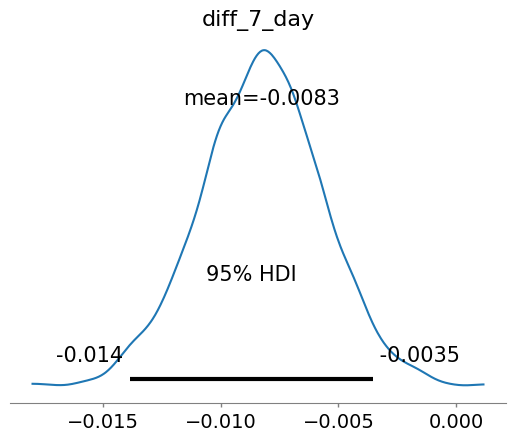

In [14]:
# Visualize posterior distributions for 7-day retention (Bernoulli A/B test)
az.plot_posterior(bernoulli_trace_7d, var_names=['diff_7_day'], hdi_prob=0.95)

# Analyze posterior distributions for 7-day retention (Bernoulli A/B test)
diff_7_day_samples = bernoulli_trace_7d.posterior['diff_7_day'].values.flatten()
diff_7_day_mean = np.mean(diff_7_day_samples)
diff_7_day_ci = np.percentile(diff_7_day_samples, [2.5, 97.5])

print(f"7-day retention difference mean (bernoulli a/b test): {diff_7_day_mean}")
print(f"7-day retention 95% credible interval (bernoulli a/b test): {diff_7_day_ci}")

(0.17, 0.2)

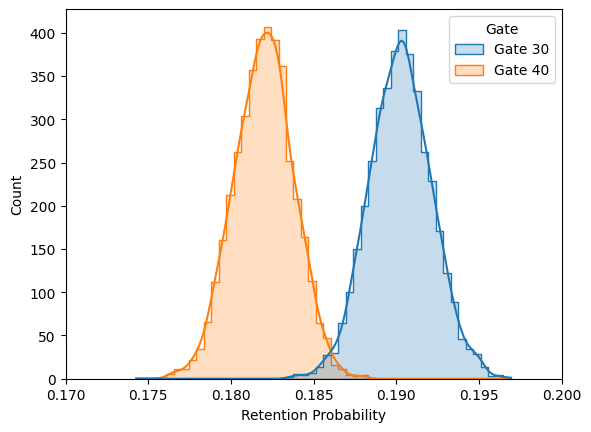

In [15]:
# Create stacked visualization for 7-day retention (Bernoulli A/B test)
p_gate_30_samples = bernoulli_trace_7d.posterior['p_gate_30_7d'].values.flatten()
p_gate_40_samples = bernoulli_trace_7d.posterior['p_gate_40_7d'].values.flatten()

p_gate_30_df = pd.DataFrame(p_gate_30_samples, columns=['Retention Probability'])
p_gate_30_df['Gate'] = 'Gate 30'

p_gate_40_df = pd.DataFrame(p_gate_40_samples, columns=['Retention Probability'])
p_gate_40_df['Gate'] = 'Gate 40'

# Concatenate dataframes and plot distributions for 7-day retention (Bernoulli A/B test)
retention_prob_data = pd.concat([p_gate_30_df, p_gate_40_df], axis=0).reset_index(drop=True)
plot = sns.histplot(data=retention_prob_data, x='Retention Probability', hue='Gate', kde=True, bins=50, element='step')
plot.set_xlim(0.17, 0.2)